# IN3050 Assignment 1

Christoffer Kleven Berg (username: chriklev)

February 20, 2020

### Running the code

Code can be found in **assignment01_solutions.ipynb**. All code is tested with Python 3.6.9 

To run the code, you need Python 3 with numpy, matplotlib, pandas and jupyter installed.

Some of the code blocks are dependant on imports or functions from other code blocks so they need to be ran in successive order.

## Imports and data parsing

In [2]:
import time
import pandas as pd
import itertools as it
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

# Read distance data to Pandas data frame and convert it to Numpy ndarray
city_distances = pd.read_csv('european_cities.csv', sep=';').to_numpy()

## Exhaustive Search

I use itertools to genereate the permutations, but I exclude one city. Using the permutations for all the cities would lead to a lot of redundant solutions because it does not matter where you start in the circle. When I am calculating the distance of the path, i then account for the excluded city.

In [5]:
def get_shortest_permutation(cities, weights=city_distances):
    # Variables for storing current shortest path
    smallest_distance = 9999999
    shortest_permutation = None

    # Iterating over all permutations excluding the first city to avoid redundant solutions
    for perm in it.permutations(cities[1:]):
        # Initializing a variable for summing up the distance and adding distances for the first city
        distance = weights[cities[0], perm[0]] + weights[perm[-1], cities[0]]
        # Summing up the distances
        for i in range(1, len(perm)):
            diff = weights[perm[i-1], perm[i]]
            distance += diff
        # If this is the shortest solution so far
        if distance < smallest_distance:
            # Update values for shortest
            smallest_distance = distance
            shortest_permutation = perm

    return (cities[0], ) + shortest_permutation, smallest_distance

In [8]:
# List with different amount of cities to solve for
ns = range(2, 11)
# Create Pandas data frame to store solutions conviniently
columns = ['Shortest path', 'Shortest distance', 'Computation time']
exhaustive_solutions = pd.DataFrame(columns=columns)

for n in ns:
    city_indices = range(n)

    t0 = time.time()
    perm, dist = get_shortest_permutation(city_indices, city_distances)
    t = time.time() - t0
    
    exhaustive_solutions.loc[n] = [perm, dist, t]

exhaustive_solutions

,Shortest path,Shortest distance,Computation time
2,"(0, 1)",3056.26,0.000019
3,"(0, 1, 2)",4024.99,0.000018
4,"(0, 1, 2, 3)",4241.89,0.000028
5,"(0, 1, 4, 2, 3)",4983.38,0.000082
6,"(0, 1, 4, 5, 2, 3)",5018.81,0.000306
7,"(0, 1, 4, 5, 2, 6, 3)",5487.89,0.002259
8,"(0, 1, 4, 5, 2, 6, 3, 7)",6667.49,0.015552
9,"(0, 1, 4, 5, 2, 6, 8, 3, 7)",6678.55,0.121821
10,"(0, 1, 9, 4, 5, 2, 6, 8, 3, 7)",7486.31,1.207400


### For 24 cities

The exhaustive search algorthm works by iterating over all permuations excluding one city. Witch means that if $n$ is number of cities, number of iterations are $(n-1)!$. For each loop it iterates over each city. This gives the algorithm a time complexity of $O((n-1)! n) = O(n!)$. We can therefor assume a linear relationship between $n!$ and used time. Taking advantage of this assumption, I fit a linear model to the time data, and extrapolate to estimate time for $n=24$.

In [7]:
# I am assuming a linear relationship between number of permutations and computation time
x = [np.math.factorial(i) for i in exhaustive_solutions.index.values]
y = exhaustive_solutions['Computation time']
beta = np.polyfit(x, y, 1)

# Extrapolating the model to estimate time for 24 cities with 24! permutations
time_all_cities = beta[0]*np.math.factorial(24) + beta[1]
print("Estimated time for all cities is %.2e years" % (time_all_cities/60/60/24))

Estimated time for all cities is 2.38e+12 years


## Hill climb

My hill climbing algorithm works by swapping random cities and seeing if the new path is better. When it has tried a certain amount of swaps without finding a better solution, it terminates.

In [23]:
def hill_climb(position, distances, accuracy):
        count = 0
        current_distance = np.sum(distances[position, np.roll(position, 1)])
        while count < accuracy:
            i = rnd.randint(len(position), size=2)
            new_position = position.copy()
            new_position[i[0]] = position[i[1]]
            new_position[i[1]] = position[i[0]]
            new_distance = np.sum(distances[new_position, np.roll(new_position, 1)])

            if new_distance < current_distance:
                position = new_position
                current_distance = new_distance
                count = 0
            else:
                count += 1
        return position, current_distance

In [24]:
rnd.seed(3050)
# Number of cities (requires: 2 <= n <= 24)
ns = list(range(2, 11)) + [24]
# Number of starting seeds
n_starts = 20
# Pandas data frame for storing solution data
columns = ['n_starts', 'Best', 'Worst', 'Mean', 'Standerd deviation', 'Time']
hill_climb_solutions = pd.DataFrame(columns=columns)

for n in ns:
    distances = np.empty(n_starts)
    
    t0 = time.time()
    for i in range(n_starts):
        position = np.arange(n)
        rnd.shuffle(position)
        pos, dist = hill_climb(position, city_distances, 1000)
        distances[i] = dist
    t = time.time() - t0

    hill_climb_solutions.loc[n] = [
        n_starts, distances.min(), distances.max(),
        distances.mean(), distances.std(ddof=1), t]

hill_climb_solutions

,n_starts,Best,Worst,Mean,Standerd deviation,Time
2,20.0,3056.26,3056.26,3056.260,4.665609e-13,0.491316
3,20.0,4024.99,4024.99,4024.990,9.331219e-13,0.483288
4,20.0,4241.89,4241.89,4241.890,0.000000e+00,0.471493
5,20.0,4983.38,4983.38,4983.380,1.794896e-12,0.480127
6,20.0,5018.81,5018.81,5018.810,8.081072e-13,0.501518
7,20.0,5487.89,5487.89,5487.890,8.602959e-13,0.492679
8,20.0,6667.49,6667.49,6667.490,9.331219e-13,0.506648
9,20.0,6678.55,7539.18,6764.613,2.648963e+02,0.509251
10,20.0,7486.31,8419.09,7754.301,3.370223e+02,0.532080
24,20.0,12287.07,16145.95,14140.772,9.783227e+02,1.135483


My hill climber algorithm is slower than exhaustive search for the first 9 cities, but finds the right solutions. After $n=10$ the hill climber starts beeing faster but does not find the best solution for all $n$. All soulutions are pretty good estimates and the hill climber is never too far from the shortest possible distance. Table for distance statistics are above indexed by $n$.



## Genetic Algorithm

For selecting parents I use fitness-proportionate selection, but first I cube the fitness scores because I found the selecten to not be selective enough with just the normal proportions. With a population of $n_p$ I select $n_p$ parents with replacement, and pair them up. Each pair of parents produce one child by partially mapped crossover and every child is mutated by swap mutation. I suspect that insert mutation would work better as it keeps more of the adjacency properties, but I did not take the time to implement it.

I am then left with $\frac{3}{2}n_p$ individuals for survivor selection. In survivor selection I again use fitness-proportionate selection with cubed scores, but I also have an elite of the three best individuals that are guaranteed to survive.

In [3]:
def evolutionary_alg(cities, pop_size, n_cycles, distances, parent_rate = 1, replace_parents=True):
    # No odd numbers please
    assert pop_size % 2 == 0

    n_parents = int(pop_size * parent_rate)
    n_parents -= n_parents%2
    n_pairs = n_parents // 2
    n_cities = len(cities)

    # Array for storing fittest individual of each run
    best_by_gen = np.empty(n_cycles)

    # Create random starting population
    population = np.empty((pop_size, n), dtype=int)
    for i in range(pop_size):
        population[i] = rnd.permutation(cities)

    # Find distance of all paths in population
    find_distance = lambda path: np.sum(distances[path, np.roll(path, 1)])
    scores = np.apply_along_axis(find_distance, 1, population)

    for i in range(n_cycles):
        # Choose parents
        inv_scores = np.power(1/scores, 3)
        portions = inv_scores/inv_scores.sum()
        i_parents = rnd.choice(pop_size, size=n_parents, replace=replace_parents, p=portions)
        # Get parents from index and reshape to 3D array for easier iteration over pairs
        parents = population[i_parents].reshape(n_pairs, 2, n_cities)
        
        # Get children
        children = create_children_pmx(parents, n_pairs, n_cities)
        # Mutate children
        mutate_children_swap(children)

        # Select new population
        population, scores = select_new_population(population, children, scores, distances)
        best_by_gen[i] = scores.min()
    return best_by_gen


def select_new_population(population, children, prev_scores, distances, elite_size = 3):
    total_population = np.concatenate((population, children))

    find_distance = lambda path: np.sum(distances[path, np.roll(path, 1)])
    children_scores = np.apply_along_axis(find_distance, 1, children)
    scores = np.concatenate((prev_scores, children_scores))

    i_sort = scores.argsort()
    i_elite = i_sort[:elite_size]
    i_not_elite = i_sort[elite_size:]

    inv_scores = np.power(1/scores[i_not_elite], 3)
    portions = inv_scores/inv_scores.sum()
    i_norm_pop = rnd.choice(
        i_not_elite, population.shape[0] - elite_size, replace=False, p=portions)
    i_pop = np.concatenate((i_norm_pop, i_elite))
    return total_population[i_pop], scores[i_pop]


def mutate_children_swap(children):
    for child in children:
        i = rnd.choice(child.size, 2, replace=False)
        child[i[0]], child[i[1]] = child[i[1]], child[i[0]]


def create_children_pmx(parents, n_pairs, n_cities):
    segment_size = n_cities // 2
    # Starting indices of each segment
    start_segments = rnd.randint(0, n_cities, size=n_pairs)
    # Copy genes from parent 1
    children = parents[:, 1].copy()
    # For each pair of parents
    for i in range(n_pairs):
        # Indices of segment to copy from parent 0, with rollover for out of bounds indices
        i_segment = (np.arange(segment_size) + start_segments[i]) % n_cities

        children[i, i_segment] = parents[i, 0, i_segment]

        # For each index in segment
        for j in i_segment:
            # If the replaced value is not in the segment it was replaced by 
            if parents[i, 1, j] not in parents[i, 0, i_segment]:
                k = np.where(parents[i, 1] == parents[i, 0, j])[0][0]
                while k in i_segment:
                    k = np.where(parents[i, 1] == parents[i, 0, k])[0][0]
                children[i, k] = parents[i, 1, j]
    return children

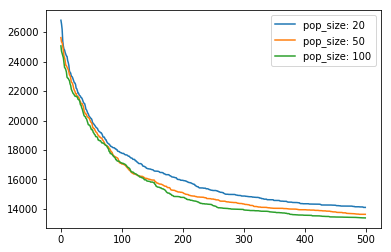

,Cycles,Best,Worst,Mean,Standerd deviation,Time [s]
20,500.0,12682.17,15614.78,14101.2200,731.389453,21.255996
50,500.0,12396.32,14668.41,13631.7545,703.779767,48.882465
100,500.0,12536.76,14717.86,13387.6445,584.607152,96.583960


In [10]:
rnd.seed(3150)
# Number of cities
n = 24
cities = np.arange(n)
# Size of population
pop_sizes = [20, 50, 100]
# Number of generations
n_cycles = 500
# Number of runs
n_runs = 20
# Pandas data frame for storing solution data
columns = ['Cycles', 'Best', 'Worst', 'Mean', 'Standerd deviation', 'Time [s]']
genetic_alg_solutions = pd.DataFrame(columns=columns)

for pop_size in pop_sizes:
    best_scores = np.empty((n_runs, n_cycles))
    t0 = time.time()
    for i in range(n_runs):
        best_scores[i] = evolutionary_alg(cities, pop_size, n_cycles, city_distances)
    t = time.time() - t0

    plt.plot(np.arange(n_cycles), best_scores.mean(0), label=("pop_size: %d" % pop_size))
    best_scores = best_scores[:, -1]
    genetic_alg_solutions.loc[pop_size] = [
        n_cycles, best_scores.min(), best_scores.max(),
        best_scores.mean(), best_scores.std(ddof=1), t]

plt.legend()
plt.show()
genetic_alg_solutions

The plot above shows best fittnes for each generation avareged over runs. The three different plots, are simulations with different population size. The table above shows the statistics of the final solutions for each run, indexed by population size.

We can see that the solution improves significantly by going from a population of 20 to 50, but the only thing that improves significantly from 50 to 100 is variation. If I had to pick one of these three I would choose 50 because the small improvements in results are not worth the doubbling in computation time. However trying 60 or 70 might be interesting to minimize variation.

In [12]:
rnd.seed(3150)
# Number of cities
ns = list(range(2, 11)) + [24]
# Size of population
pop_sizes = 50
# Number of generations
n_cycles = 500
# Pandas data frame for storing solution data
columns = ['Distance', 'Time [s]', 'Inspected tours', '(n-1)!']
genetic_alg_solutions_2 = pd.DataFrame(columns=columns)

for n in ns:
    cities = np.arange(n)
    
    t0 = time.time()
    best_scores = evolutionary_alg(cities, pop_size, n_cycles, city_distances)
    t = time.time() - t0

    # For each cycle it introduces pop_size//2 new individuals
    inspected_tours = pop_size + pop_size // 2 * n_cycles
    genetic_alg_solutions_2.loc[n] = [best_scores[-1], t, inspected_tours, np.math.factorial(n-1)]

genetic_alg_solutions_2

,Distance,Time [s],Inspected tours,(n-1)!
2,3056.26,2.586313,25100.0,1
3,4024.99,2.859653,25100.0,2
4,4241.89,2.855223,25100.0,6
5,4983.38,3.301100,25100.0,24
6,5018.81,3.473626,25100.0,120
7,5487.89,3.163379,25100.0,720
8,6667.49,3.303437,25100.0,5040
9,6678.55,3.243750,25100.0,40320
10,7486.31,3.446489,25100.0,362880
24,13019.43,4.741485,25100.0,25852016738884976640000


The table above shows solutions for the genetic algorithm ran once, indexed by number of cities. For $n \leq 10$ the genetic algorithm finds the correct solution, but uses a lot more time. For $n=24$ the genetic algorithm comes reasonably close and executes in a reasonable time, unlike the exhaustive search. The two last columns show number of tours inspected by the GA and exhaustive search respectivly. For $n < 9$ the GA inspects way more tours and is obviously worse. For $n \geq 9$ number of tours the exhaustive search has to inspect increases rapidly, but for the GA it stays the same.